In [1]:
from naslib.utils.io import read_json
import pandas as pd


In [14]:
KEY = "valid_acc"

values = {}
for seed in range(5):
    no_calibrated_path = f"/Users/chengchen/Desktop/Experiments/bananas__ensemble_mlp__gaussian/nasbench201/cifar10/search_epochs=150/seed={seed}/errors.json"
    value = read_json(no_calibrated_path)[KEY]
    values[f"seed={seed}"] = value

df_bananas = pd.DataFrame(values)
df_bananas["aggregated"] = df_bananas.mean(axis=1)

In [15]:
values = {}
for seed in range(5):
    no_calibrated_path = f"/Users/chengchen/Desktop/Experiments/bananas__ensemble_mlp__CP_split/nasbench201/cifar10/acq=its__train_cal_split=03__num_quantiles=10/search_epochs=150/seed={seed}/errors.json"
    value = read_json(no_calibrated_path)[KEY]
    values[f"seed={seed}"] = value

df_scp_3 = pd.DataFrame(values)
df_scp_3["aggregated"] = df_scp_3.mean(axis=1)

In [16]:
values = {}
for seed in range(5):
    no_calibrated_path = f"/Users/chengchen/Desktop/Experiments/bananas__ensemble_mlp__CP_split/nasbench201/cifar10/acq=its__train_cal_split=05__num_quantiles=10/search_epochs=150/seed={seed}/errors.json"
    value = read_json(no_calibrated_path)[KEY]
    values[f"seed={seed}"] = value

df_scp_5 = pd.DataFrame(values)
df_scp_5["aggregated"] = df_scp_5.mean(axis=1)

In [26]:
import matplotlib.pyplot as plt
import math

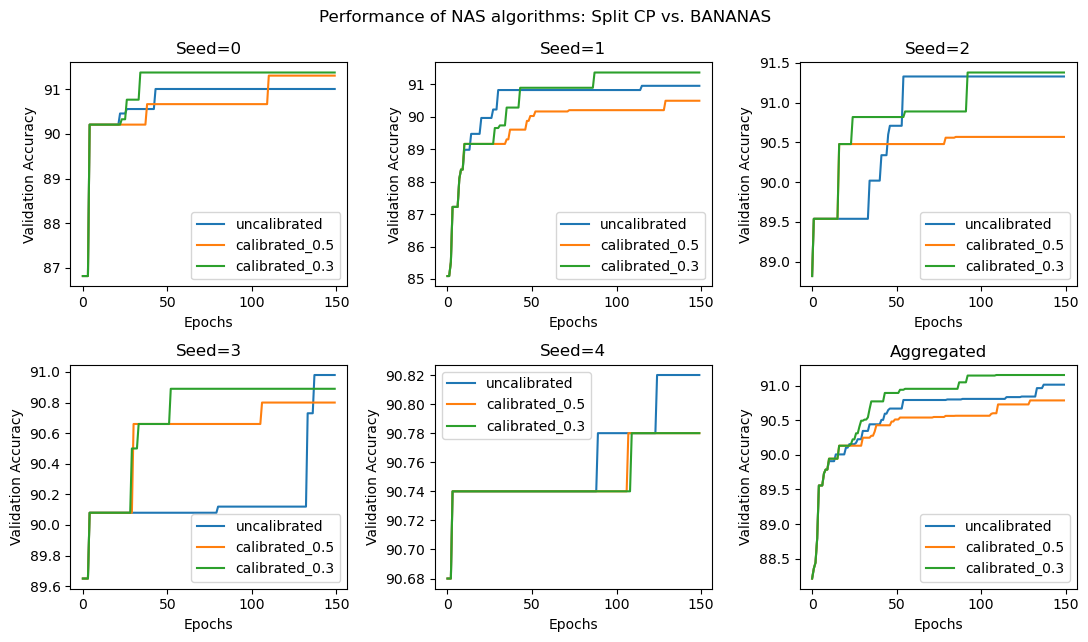

In [68]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(11, 6.5))
plt.suptitle("Performance of NAS algorithms: Split CP vs. BANANAS")
for i, col in enumerate(df_bananas.columns):
    j = math.floor(i / 3)
    n = i % 3
    ax = axes[j, n]
    ax.title.set_text(col.capitalize())
    ax.plot(df_bananas[col], label="uncalibrated") 
    ax.plot(df_scp_5[col], label="calibrated_0.5") 
    ax.plot(df_scp_3[col], label="calibrated_0.3") 
    ax.legend()
    ax.set_ylabel("Validation Accuracy")
    ax.set_xlabel("Epochs")

plt.tight_layout()

#### Running time (5 trials)
- BANANAS: around 1.5h
- Calibrated: around 40 mins